# Table of Contents

* [Covid-19 Data Exploration](#chapter1)
    * [Data](#section_1_1)
    * [To DataFrames](#section_1_2)
    * [Exploration](#section_1_3)

* [Data Completeness](#chapter2)
    * *[Distribution Plot](#section_2_1)*
    
* [Data Regularity](#chapter3)
    * [Scaler Functions](#section_3_1)
    
* [Data Consistency](#chapter4)
    
* [EDA](#chapter5)
    * [Satisfaction Data](#section_5_1)
    * [Gravity](#section_5_2)
    * [Gender](#section_5_3)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

In [2]:
data_path = os.path.join('data', 'eda_fe')

In [3]:
%matplotlib inline
plt.style.use('dark_background')
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', None)

# 1. Covid-19 Data Exploration<a class="anchor" id="chapter1"></a>

This notebook shows how data can be downloaded from https://coronavirus.data.gov.uk/developers-guide and transformed into a DataFrame.

Your task is to explore this data and report back on integrity and characteristics of the data:
- completeness, regularity, consistency
- characteristics and patterns, observed both in single columns and across different aspects of data 

You may download additional data from the resource, or use the existing set-up to explore the data currently downloaded. 


## Data<a class="anchor" id="section_1_1"></a>

https://coronavirus.data.gov.uk/developers-guide

notes:
- this block downloads `newCasesByPublishDate, cumCasesByPublishDate, newDeathsByDeathDate, cumDeathsByDeathDate`
- further data can be accessed by adding terms to the `cases_and_deaths_structure` -- from the above webpage, use the   block titled *See a list of valid metrics for structure* for details of the additional data available. 
- data is published at different levels of area granularity -- for example 'ltla' stands for 'lower-tier local authority' and is the most fine-grained resolution. Each level of granularity is saved in a separate json file.   

In [6]:
from uk_covid19 import Cov19API
import json

area_types = ['ltla', 'utla', 'nhsRegion', 'region', 'nation']

for area_type in tqdm(area_types):
    
    filters = [
        f'areaType={area_type}'
    ]   
    
    cases_and_deaths_structure = {
        "date": "date",
        "areaName": "areaName",
        "areaCode": "areaCode",
        "newCasesByPublishDate": "newCasesByPublishDate",
        "cumCasesByPublishDate": "cumCasesByPublishDate",
        "newDeathsByDeathDate": "newDeathsByDeathDate",
        "cumDeathsByDeathDate": "cumDeathsByDeathDate"

    }    

    api = Cov19API(filters=filters, structure=cases_and_deaths_structure)
    data = api.get_json()
    path = os.path.join(data_path, f'list_of_{area_type}.json')
    json.dump(data, open(path, 'wt'), indent=4, sort_keys=True)


100%|████████████████████████████████████████████████████████████████████████████| 5/5 [02:41<00:00, 32.35s/it]


## To Dataframes<a class="anchor" id="section_1_2"></a>

- one dataframe per level of spatial resolution (nation, region, local authority etc)
- note that only one type of data is loaded into each dataframe -- in this case, `newCasesByPublishDate`. You can edit the case to load in different types of data.
- The rows of each dataframe correspond to dates
- The columns of each dataframe correspond to different areas


In [7]:
import datetime as dt

def get_dataframe(nested_data, data_type):
    
    dict_of_area_data = {}
    
    for input_d in nested_data:
        
        area_name = input_d['areaName']
        
        if area_name not in dict_of_area_data.keys():
            dict_of_area_data[area_name] = {}
            
        date = dt.datetime.strptime(input_d['date'], '%Y-%m-%d')
        
        dict_of_area_data[area_name][date] = input_d[data_type]
        # print(f"area name is {input_d['areaName']} and date is {input_d['date']}")

    # print(f'there are {len(dict_of_area_data)} areas')
    series_dict = {}
    
    for area in dict_of_area_data:
        # print (f'area {area} has {len(dict_of_area_data[area])} dates')
        s = pd.Series(list(dict_of_area_data[area].values()), index = list(dict_of_area_data[area].keys()))
        series_dict[area] = s
        
    df = pd.DataFrame(series_dict)
    df = df.sort_index()
    
    return df

In [163]:
%%time

area_types = ['ltla', 'utla', 'nhsRegion', 'region', 'nation']

df_dict = {}

for area_type in area_types:
    
    path = os.path.join(data_path, f'list_of_{area_type}.json')
    
    json_data = json.load(open(path))
    
    df_dict[area_type] = get_dataframe(json_data['data'], 'newCasesByPublishDate')
    
    print(f"df_dict['{area_type}'] has {len(df_dict[area_type].index)} rows and {len(df_dict[area_type].columns)} cols")

df_dict['ltla'] has 762 rows and 380 cols
df_dict['utla'] has 762 rows and 214 cols
df_dict['nhsRegion'] has 0 rows and 0 cols
df_dict['region'] has 762 rows and 9 cols
df_dict['nation'] has 839 rows and 4 cols
CPU times: total: 13.5 s
Wall time: 13.7 s


## Exploration<a class="anchor" id="section_1_3"></a>

In [164]:
# look at the dataframes

ltla = df_dict['ltla']
utla = df_dict['utla']
nhsRegion = df_dict['nhsRegion'] #all zero
region = df_dict['region']
nation = df_dict['nation']

In [165]:
ltla

,South Gloucestershire,Aylesbury Vale,Cheltenham,Craven,Staffordshire Moorlands,Surrey Heath,Rugby,Tameside,Dudley,Hackney and City of London,Antrim and Newtownabbey,Gwynedd,Luton,Southend-on-Sea,Shropshire,Gloucester,Sevenoaks,South Ribble,Hinckley and Bosworth,Newark and Sherwood,Manchester,Rochdale,Sunderland,Ceredigion,Peterborough,South Derbyshire,Swale,Fylde,Harborough,North Kesteven,Scarborough,Mansfield,Barking and Dagenham,Camden,Redbridge,"Armagh City, Banbridge and Craigavon",North East Lincolnshire,Derby,Southampton,Cambridge,East Cambridgeshire,Braintree,Broxbourne,Blaby,Boston,West Oxfordshire,Mole Valley,Medway,Dorset,Eden,Tendring,Breckland,North Norfolk,Redditch,Wychavon,North Ayrshire,Argyll and Bute,Denbighshire,Blaenau Gwent,Stoke-on-Trent,Cheshire West and Chester,Harlow,Broadland,Cherwell,Waverley,Woking,Worcester,Gateshead,Derry City and Strabane,Fife,Conwy,Northumberland,South Cambridgeshire,Allerdale,Thanet,South Holland,West Suffolk,North Tyneside,Kingston upon Thames,Richmond upon Thames,Wandsworth,Glasgow City,Carmarthenshire,Colchester,Chorley,Kettering,Ashfield,Mid Suffolk,Elmbridge,Tandridge,Newcastle upon Tyne,Wolverhampton,Lambeth,Vale of Glamorgan,Blackpool,Plymouth,"Bournemouth, Christchurch and Poole",East Devon,Rushmoor,Tonbridge and Malling,Tunbridge Wells,Great Yarmouth,South Norfolk,Epsom and Ewell,East Hertfordshire,Bradford,Derbyshire Dales,Brentwood,Test Valley,Pendle,Rossendale,King's Lynn and West Norfolk,Rushcliffe,South Oxfordshire,Bromley,Croydon,Lisburn and Castlereagh,Wrexham,North Somerset,Slough,Central Bedfordshire,Chesterfield,Teignbridge,Richmondshire,Wyre Forest,Barnsley,Birmingham,East Ayrshire,West Lothian,Forest of Dean,Fareham,Burnley,Lancaster,Tamworth,Bromsgrove,Bury,Haringey,Islington,Highland,Monmouthshire,Newport,West Berkshire,South Lakeland,Mid Devon,Eastleigh,Ribble Valley,Lichfield,Babergh,Guildford,Reigate and Banstead,Stratford-on-Avon,Kirklees,Havering,"Kingston upon Hull, City of",Wiltshire,West Devon,Hastings,Oadby and Wigston,Ipswich,Nuneaton and Bedworth,Welwyn Hatfield,Sutton,Clackmannanshire,Stirling,Rhondda Cynon Taf,North Lincolnshire,"Bristol, City of",Swindon,North Hertfordshire,Three Rivers,Somerset West and Taunton,Wigan,Sefton,Solihull,Enfield,North Lanarkshire,Bath and North East Somerset,North Devon,Ashford,Hyndburn,Daventry,East Staffordshire,Spelthorne,Adur,Harrow,Mid Ulster,Na h-Eileanan Siar,Cardiff,York,Fenland,Torridge,Stroud,East Hampshire,Hertsmere,East Northamptonshire,Mid Sussex,Walsall,Hillingdon,Orkney Islands,South Lanarkshire,Rutland,South Hams,Wellingborough,Oxford,Warwick,Hounslow,East Lothian,East Renfrewshire,East Dunbartonshire,Isle of Anglesey,Swansea,Bridgend,Isle of Wight,County Durham,Lewes,Wyre,Norwich,Mendip,Chichester,Knowsley,Wakefield,Hammersmith and Fulham,Renfrewshire,Neath Port Talbot,South Bucks,Epping Forest,Winchester,Folkestone and Hythe,Northampton,Vale of White Horse,South Somerset,Newcastle-under-Lyme,Westminster,Falkirk,Torfaen,Powys,Torbay,Bedford,Maidstone,Lincoln,Harrogate,Lewisham,Causeway Coast and Glens,Moray,Shetland Islands,Aberdeen City,West Dunbartonshire,Angus,Redcar and Cleveland,Halton,Nottingham,Brighton and Hove,Uttlesford,Havant,Dover,Cannock Chase,Wirral,Calderdale,City of Edinburgh,Pembrokeshire,Hartlepool,East Riding of Yorkshire,Wycombe,Carlisle,Erewash,North East Derbyshire,Dartford,South Kesteven,West Lindsey,Bexley,Waltham Forest,Midlothian,Eastbourne,Maldon,Corby,Broxtowe,Sedgemoor,Crawley,St Albans,Salford,South Tyneside,Sandwell,Ards and North Down,Amber Valley,High Peak,Watford,South Northamptonshire,Ryedale,South Staffordshire,North Warwickshire,St. Helens,Rotherham,Greenwich,Kensington and Chelsea,Southwark,Blackburn with Darwen,Milton Keynes,Tewkesbury,West Lancashire,North West Leicestershire,Gedling,Stafford,Horsham,Trafford,Tower Hamlets,Dumfries and Galloway,South Ayrshire,Thurrock,Windsor and Maidenhead,Wokingham,Cheshire East,New Forest,Worthing,Stevenage,Sheffield,Ea

In [166]:
ltla.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 762 entries, 2020-04-17 to 2022-05-18
Freq: D
Columns: 380 entries, South Gloucestershire to Caerphilly
dtypes: float64(380)
memory usage: 2.2 MB


In [167]:
ltla.describe()

,South Gloucestershire,Aylesbury Vale,Cheltenham,Craven,Staffordshire Moorlands,Surrey Heath,Rugby,Tameside,Dudley,Hackney and City of London,Antrim and Newtownabbey,Gwynedd,Luton,Southend-on-Sea,Shropshire,Gloucester,Sevenoaks,South Ribble,Hinckley and Bosworth,Newark and Sherwood,Manchester,Rochdale,Sunderland,Ceredigion,Peterborough,South Derbyshire,Swale,Fylde,Harborough,North Kesteven,Scarborough,Mansfield,Barking and Dagenham,Camden,Redbridge,"Armagh City, Banbridge and Craigavon",North East Lincolnshire,Derby,Southampton,Cambridge,East Cambridgeshire,Braintree,Broxbourne,Blaby,Boston,West Oxfordshire,Mole Valley,Medway,Dorset,Eden,Tendring,Breckland,North Norfolk,Redditch,Wychavon,North Ayrshire,Argyll and Bute,Denbighshire,Blaenau Gwent,Stoke-on-Trent,Cheshire West and Chester,Harlow,Broadland,Cherwell,Waverley,Woking,Worcester,Gateshead,Derry City and Strabane,Fife,Conwy,Northumberland,South Cambridgeshire,Allerdale,Thanet,South Holland,West Suffolk,North Tyneside,Kingston upon Thames,Richmond upon Thames,Wandsworth,Glasgow City,Carmarthenshire,Colchester,Chorley,Kettering,Ashfield,Mid Suffolk,Elmbridge,Tandridge,Newcastle upon Tyne,Wolverhampton,Lambeth,Vale of Glamorgan,Blackpool,Plymouth,"Bournemouth, Christchurch and Poole",East Devon,Rushmoor,Tonbridge and Malling,Tunbridge Wells,Great Yarmouth,South Norfolk,Epsom and Ewell,East Hertfordshire,Bradford,Derbyshire Dales,Brentwood,Test Valley,Pendle,Rossendale,King's Lynn and West Norfolk,Rushcliffe,South Oxfordshire,Bromley,Croydon,Lisburn and Castlereagh,Wrexham,North Somerset,Slough,Central Bedfordshire,Chesterfield,Teignbridge,Richmondshire,Wyre Forest,Barnsley,Birmingham,East Ayrshire,West Lothian,Forest of Dean,Fareham,Burnley,Lancaster,Tamworth,Bromsgrove,Bury,Haringey,Islington,Highland,Monmouthshire,Newport,West Berkshire,South Lakeland,Mid Devon,Eastleigh,Ribble Valley,Lichfield,Babergh,Guildford,Reigate and Banstead,Stratford-on-Avon,Kirklees,Havering,"Kingston upon Hull, City of",Wiltshire,West Devon,Hastings,Oadby and Wigston,Ipswich,Nuneaton and Bedworth,Welwyn Hatfield,Sutton,Clackmannanshire,Stirling,Rhondda Cynon Taf,North Lincolnshire,"Bristol, City of",Swindon,North Hertfordshire,Three Rivers,Somerset West and Taunton,Wigan,Sefton,Solihull,Enfield,North Lanarkshire,Bath and North East Somerset,North Devon,Ashford,Hyndburn,Daventry,East Staffordshire,Spelthorne,Adur,Harrow,Mid Ulster,Na h-Eileanan Siar,Cardiff,York,Fenland,Torridge,Stroud,East Hampshire,Hertsmere,East Northamptonshire,Mid Sussex,Walsall,Hillingdon,Orkney Islands,South Lanarkshire,Rutland,South Hams,Wellingborough,Oxford,Warwick,Hounslow,East Lothian,East Renfrewshire,East Dunbartonshire,Isle of Anglesey,Swansea,Bridgend,Isle of Wight,County Durham,Lewes,Wyre,Norwich,Mendip,Chichester,Knowsley,Wakefield,Hammersmith and Fulham,Renfrewshire,Neath Port Talbot,South Bucks,Epping Forest,Winchester,Folkestone and Hythe,Northampton,Vale of White Horse,South Somerset,Newcastle-under-Lyme,Westminster,Falkirk,Torfaen,Powys,Torbay,Bedford,Maidstone,Lincoln,Harrogate,Lewisham,Causeway Coast and Glens,Moray,Shetland Islands,Aberdeen City,West Dunbartonshire,Angus,Redcar and Cleveland,Halton,Nottingham,Brighton and Hove,Uttlesford,Havant,Dover,Cannock Chase,Wirral,Calderdale,City of Edinburgh,Pembrokeshire,Hartlepool,East Riding of Yorkshire,Wycombe,Carlisle,Erewash,North East Derbyshire,Dartford,South Kesteven,West Lindsey,Bexley,Waltham Forest,Midlothian,Eastbourne,Maldon,Corby,Broxtowe,Sedgemoor,Crawley,St Albans,Salford,South Tyneside,Sandwell,Ards and North Down,Amber Valley,High Peak,Watford,South Northamptonshire,Ryedale,South Staffordshire,North Warwickshire,St. Helens,Rotherham,Greenwich,Kensington and Chelsea,Southwark,Blackburn with Darwen,Milton Keynes,Tewkesbury,West Lancashire,North West Leicestershire,Gedling,Stafford,Horsham,Trafford,Tower Hamlets,Dumfries and Galloway,South Ayrshire,Thurrock,Windsor and Maidenhead,Wokingham,Cheshire East,New Forest,Worthing,Stevenage,Sheffield,Ea

In [168]:
# proportion of null entries per column

(ltla.isna().sum()/len(ltla)).sort_values(ascending=False)

Na h-Eileanan Siar                      0.186352
Fermanagh and Omagh                     0.173228
Armagh City, Banbridge and Craigavon    0.164042
Newry, Mourne and Down                  0.164042
Derry City and Strabane                 0.164042
Mid Ulster                              0.164042
Belfast                                 0.162730
Mid and East Antrim                     0.162730
Ards and North Down                     0.162730
Causeway Coast and Glens                0.162730
Lisburn and Castlereagh                 0.162730
Antrim and Newtownabbey                 0.162730
Orkney Islands                          0.157480
Clackmannanshire                        0.152231
Shetland Islands                        0.152231
Scottish Borders                        0.150919
North Ayrshire                          0.149606
South Ayrshire                          0.146982
East Renfrewshire                       0.143045
West Dunbartonshire                     0.141732
Argyll and Bute     

<AxesSubplot:>

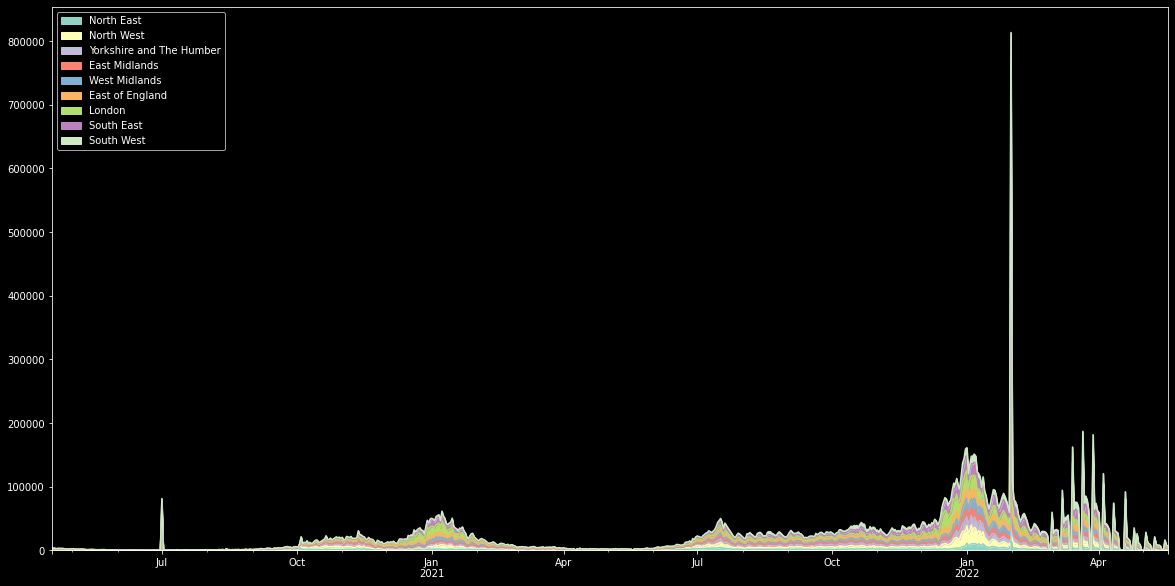

In [169]:
# stacked area plot

region.plot.area(stacked=True, figsize=(20,10))

# 2. Data Completeness<a class="anchor" id="chapter2"></a>

You need to check that your data is complete, or fix it in cases that it is not.
- Check for NULLs
- Get variable statistics
- Find index if there is one
- Remove any unhelpful rows / columns
- Replace / remove missing values
- *Visualising a variable's distribution*

In [4]:
filepath = os.path.join(data_path,'titanic', 'titanic_train.csv')
df = pd.read_csv(filepath)
df.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [7]:
# looks like passenger id is the index of the data

df = pd.read_csv(filepath, index_col='PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


NULL proportions:
Cabin       0.771044
Age         0.198653
Embarked    0.002245
Survived    0.000000
Pclass      0.000000
Name        0.000000
Sex         0.000000
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
dtype: float64


<AxesSubplot:ylabel='PassengerId'>

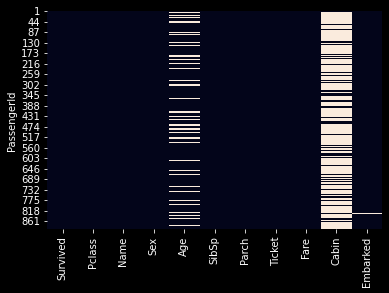

In [8]:
import seaborn as sns

def proportion_null(df):
    return (df.isna().sum()/len(df)).sort_values(ascending=False)

print(f'NULL proportions:\n{proportion_null(df)}')

sns.heatmap(df.isnull(), cbar=False)

In [9]:
# drop cabin

df = df.drop(columns=['Cabin'])
df

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
PassengerId,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...
887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,S
888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,S
889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,S


In [10]:
# replace missing values

print(f"{df['Embarked'].value_counts()}\n")
mask = df['Embarked'].isnull() # isolate the null values

df.loc[mask, 'Embarked'] = 'X' # gets the nulls included as X
print(df['Embarked'].value_counts())

S    644
C    168
Q     77
Name: Embarked, dtype: int64

S    644
C    168
Q     77
X      2
Name: Embarked, dtype: int64


## Distribution Plot<a class="anchor" id="section_2_1"></a>

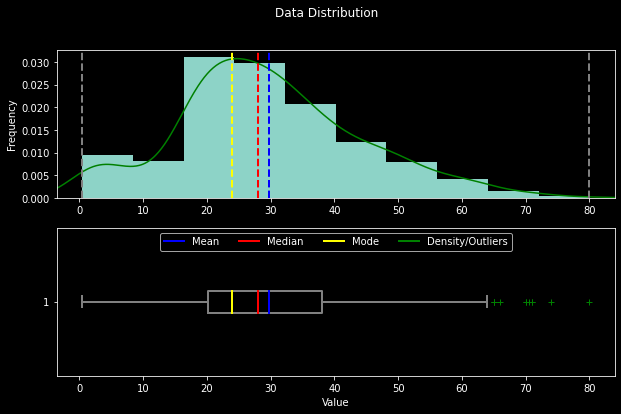

In [12]:
from matplotlib.lines import Line2D

def plot_distribution(variable):
    
    min_val  = variable.min()
    max_val  = variable.max()
    mean_val = variable.mean()
    med_val  = variable.median()
    mod_val  = variable.mode()[0]
    
    fig, ax = plt.subplots(2, 1, figsize = (10,6))
    ax[0].hist(variable, density=True)
    variable.plot.density(ax=ax[0], color='green')
    ax[0].set_ylabel('Frequency')
    
    ax[0].axvline(
        x=min_val, color = 'gray', linestyle='dashed', linewidth = 2
    )
    ax[0].axvline(
        x=mean_val, color = 'blue', linestyle='dashed', linewidth = 2
    )
    ax[0].axvline(
        x=med_val, color = 'red', linestyle='dashed', linewidth = 2
    )
    ax[0].axvline(
        x=mod_val, color = 'yellow', linestyle='dashed', linewidth = 2
    )
    ax[0].axvline(
        x=max_val, color = 'gray', linestyle='dashed', linewidth = 2
    )
    
    bp = ax[1].boxplot(
        variable, vert=False, meanline=True, showmeans=True, showfliers=True, sym="g+"
    )
    
    for element in ['boxes', 'whiskers', 'fliers', 'caps']:
        plt.setp(bp[element], color='gray', linewidth=2)
    
    for median in bp['medians']: 
        median.set(color ='red', linewidth = 2)
    
    for mean in bp['means']: 
        mean.set(color ='blue', linewidth = 2, linestyle='-') 
    
    ax[1].axvline(
        x=mod_val, color = 'yellow', linestyle='-', linewidth = 2, ymin=0.425, ymax=0.575
    )
    ax[1].set_xlabel('Value')
    
    custom_lines = [
        Line2D([0], [0], color='blue', lw=2), 
        Line2D([0], [0], color='red', lw=2), 
        Line2D([0], [0], color='yellow', lw=2), 
        Line2D([0], [0], color='green', lw=2)
    ]
    
    ax[1].legend(
        custom_lines, 
        ['Mean', 'Median', 'Mode', 'Density/Outliers'], 
        loc='upper center', 
        bbox_to_anchor=(0.5, 1.00),
        ncol=4
    )
    
    xmin, xmax = ax[1].get_xlim()
    ax[0].set_xlim([xmin, xmax])
    
    fig.suptitle('Data Distribution')
    plt.show()
    
plot_distribution(df['Age'].dropna())

# 3. Data Regularity<a class="anchor" id="chapter3"></a>

Data at vastly different scales will be difficult to model.
Understand the type of data you have:
- can you apply any transforms?
    - large values: log (non-negative), square root (+ and -)
    - small values: exponential
    - normalisation (min-max scaling)
    - standardisation (mean 0 std 1 scaling)
- different variable types
    - int vs float
    - categoricals
    - dates, times


In [60]:
filepath = os.path.join(data_path, 'credit_card', 'UCI_Credit_Card.csv')
df = pd.read_csv(filepath)
df

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,29996,220000.0,1,3,1,39,0,0,0,0,0,0,188948.0,192815.0,208365.0,88004.0,31237.0,15980.0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0,0
29996,29997,150000.0,1,3,2,43,-1,-1,-1,-1,0,0,1683.0,1828.0,3502.0,8979.0,5190.0,0.0,1837.0,3526.0,8998.0,129.0,0.0,0.0,0
29997,29998,30000.0,1,2,2,37,4,3,2,-1,0,0,3565.0,3356.0,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,0,-1,-1645.0,78379.0,76304.0,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1


In [61]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

In [62]:
df = df.rename(columns={'PAY_0':'PAY_1', 'default.payment.next.month':'DEF'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ID         30000 non-null  int64  
 1   LIMIT_BAL  30000 non-null  float64
 2   SEX        30000 non-null  int64  
 3   EDUCATION  30000 non-null  int64  
 4   MARRIAGE   30000 non-null  int64  
 5   AGE        30000 non-null  int64  
 6   PAY_1      30000 non-null  int64  
 7   PAY_2      30000 non-null  int64  
 8   PAY_3      30000 non-null  int64  
 9   PAY_4      30000 non-null  int64  
 10  PAY_5      30000 non-null  int64  
 11  PAY_6      30000 non-null  int64  
 12  BILL_AMT1  30000 non-null  float64
 13  BILL_AMT2  30000 non-null  float64
 14  BILL_AMT3  30000 non-null  float64
 15  BILL_AMT4  30000 non-null  float64
 16  BILL_AMT5  30000 non-null  float64
 17  BILL_AMT6  30000 non-null  float64
 18  PAY_AMT1   30000 non-null  float64
 19  PAY_AMT2   30000 non-null  float64
 20  PAY_AM

In [63]:
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEF
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [64]:
# log transform a variable with large values, notice double brackets

df[['LIMIT_BAL']] = df[['LIMIT_BAL']].applymap(lambda x: np.log(x))
df.describe()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEF
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,11.663002,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,0.941135,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,9.210340,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,10.819778,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,11.849398,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,12.388394,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,13.815511,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [65]:
df['MARRIAGE'].value_counts()

2    15964
1    13659
3      323
0       54
Name: MARRIAGE, dtype: int64

In [66]:
# -1=pay duly, 1=payment delay for one month, 2=payment delay for two months, 
# … 8=payment delay for eight months, 9=payment delay for nine months and above

df[['PAY_1', 'PAY_2', 'PAY_3', 'PAY_4']].head()

,PAY_1,PAY_2,PAY_3,PAY_4
0,2,2,-1,-1
1,-1,2,0,0
2,0,0,0,0
3,0,0,0,0
4,-1,0,-1,0


In [67]:
df[[column for column in df.columns if 'PAY_' in column]]

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,2,2,-1,-1,-2,-2,0.0,689.0,0.0,0.0,0.0,0.0
1,-1,2,0,0,0,2,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,0,0,0,0,0,0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,0,0,0,0,0,0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,-1,0,-1,0,0,0,2000.0,36681.0,10000.0,9000.0,689.0,679.0
...,...,...,...,...,...,...,...,...,...,...,...,...
29995,0,0,0,0,0,0,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0
29996,-1,-1,-1,-1,0,0,1837.0,3526.0,8998.0,129.0,0.0,0.0
29997,4,3,2,-1,0,0,0.0,0.0,22000.0,4200.0,2000.0,3100.0
29998,1,-1,0,0,0,-1,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0


In [68]:
pay_cols = [
    column for 
    column in 
    df.columns if 
    (('PAY_' in column)&('AMT' not in column))
]

df[pay_cols]

,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6
0,2,2,-1,-1,-2,-2
1,-1,2,0,0,0,2
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,-1,0,-1,0,0,0
...,...,...,...,...,...,...
29995,0,0,0,0,0,0
29996,-1,-1,-1,-1,0,0
29997,4,3,2,-1,0,0
29998,1,-1,0,0,0,-1


In [69]:
df[pay_cols].value_counts() # does this altogether

PAY_1  PAY_2  PAY_3  PAY_4  PAY_5  PAY_6
 0      0      0      0      0      0       9821
-2     -2     -2     -2     -2     -2       2109
-1     -1     -1     -1     -1     -1       1992
 1     -2     -2     -2     -2     -2        651
 2      2      2      2      2      2        530
                                            ... 
       -1      2      2      2      0          1
                            -1      0          1
                            -2     -1          1
                                   -2          1
 1     -1      2      2      2     -1          1
Length: 1106, dtype: int64

In [70]:
# if using this data you need to understand what -1 and -2 mean

for col in pay_cols:
    
    print(f"{df[col].value_counts()}\n")

 0    14737
-1     5686
 1     3688
-2     2759
 2     2667
 3      322
 4       76
 5       26
 8       19
 6       11
 7        9
Name: PAY_1, dtype: int64

 0    15730
-1     6050
 2     3927
-2     3782
 3      326
 4       99
 1       28
 5       25
 7       20
 6       12
 8        1
Name: PAY_2, dtype: int64

 0    15764
-1     5938
-2     4085
 2     3819
 3      240
 4       76
 7       27
 6       23
 5       21
 1        4
 8        3
Name: PAY_3, dtype: int64

 0    16455
-1     5687
-2     4348
 2     3159
 3      180
 4       69
 7       58
 5       35
 6        5
 1        2
 8        2
Name: PAY_4, dtype: int64

 0    16947
-1     5539
-2     4546
 2     2626
 3      178
 4       84
 7       58
 5       17
 6        4
 8        1
Name: PAY_5, dtype: int64

 0    16286
-1     5740
-2     4895
 2     2766
 3      184
 4       49
 7       46
 6       19
 5       13
 8        2
Name: PAY_6, dtype: int64



In [71]:
# replace negatives with 0

df[['PAY_1']].applymap(lambda x: max(x,0)).value_counts()

PAY_1
0        23182
1         3688
2         2667
3          322
4           76
5           26
8           19
6           11
7            9
dtype: int64

## Scaler functions<a class="anchor" id="section_3_1"></a>

In [72]:
cols = [column for column in df.columns if 'PAY_AMT' in column]

df[cols]

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.0,689.0,0.0,0.0,0.0,0.0
1,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,2000.0,36681.0,10000.0,9000.0,689.0,679.0
...,...,...,...,...,...,...
29995,8500.0,20000.0,5003.0,3047.0,5000.0,1000.0
29996,1837.0,3526.0,8998.0,129.0,0.0,0.0
29997,0.0,0.0,22000.0,4200.0,2000.0,3100.0
29998,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0


In [74]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
pd.DataFrame(scaler.fit_transform(df[cols].values), columns=cols)

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783
2,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
3,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
4,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284
...,...,...,...,...,...,...
29995,0.009730,0.011875,0.005583,0.004907,0.011723,0.001892
29996,0.002103,0.002094,0.010042,0.000208,0.000000,0.000000
29997,0.000000,0.000000,0.024552,0.006763,0.004689,0.005864
29998,0.098334,0.002024,0.001315,0.003101,0.124174,0.003412


In [75]:
from sklearn.preprocessing import MinMaxScaler

# you can even set your own range
scaler = MinMaxScaler(feature_range=(5, 10))
pd.DataFrame(scaler.fit_transform(df[cols].values), columns=cols)

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,5.000000,5.002045,5.000000,5.000000,5.000000,5.000000
1,5.000000,5.002969,5.005580,5.008052,5.000000,5.018916
2,5.008689,5.004453,5.005580,5.008052,5.011723,5.047289
3,5.011448,5.005994,5.006696,5.008857,5.012531,5.009458
4,5.011448,5.108894,5.055801,5.072464,5.008077,5.006422
...,...,...,...,...,...,...
29995,5.048652,5.059373,5.027917,5.024533,5.058613,5.009458
29996,5.010515,5.010468,5.050210,5.001039,5.000000,5.000000
29997,5.000000,5.000000,5.122762,5.033816,5.023445,5.029319
29998,5.491671,5.010120,5.006573,5.015507,5.620872,5.017062


In [76]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
pd.DataFrame(scaler.fit_transform(df[cols].values), columns=cols)

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-0.341942,-0.227086,-0.296801,-0.308063,-0.314136,-0.293382
1,-0.341942,-0.213588,-0.240005,-0.244230,-0.314136,-0.180878
2,-0.250292,-0.191887,-0.240005,-0.244230,-0.248683,-0.012122
3,-0.221191,-0.169361,-0.228645,-0.237846,-0.244166,-0.237130
4,-0.221191,1.335034,0.271165,0.266434,-0.269039,-0.255187
...,...,...,...,...,...,...
29995,0.171250,0.611048,-0.012648,-0.113564,0.013131,-0.237130
29996,-0.231032,-0.103955,0.214255,-0.299828,-0.314136,-0.293382
29997,-0.341942,-0.256990,0.952725,-0.039964,-0.183229,-0.119001
29998,4.844316,-0.109033,-0.229895,-0.185120,3.152536,-0.191904


In [77]:
from sklearn.preprocessing import MaxAbsScaler

# the MaxAbs scaler takes the absolute maximum value of each column 
# and divides each value in the column by the maximum value.

scaler = MaxAbsScaler()
pd.DataFrame(scaler.fit_transform(df[cols].values), columns=cols)

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.000000,0.000409,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000594,0.001116,0.001610,0.000000,0.003783
2,0.001738,0.000891,0.001116,0.001610,0.002345,0.009458
3,0.002290,0.001199,0.001339,0.001771,0.002506,0.001892
4,0.002290,0.021779,0.011160,0.014493,0.001615,0.001284
...,...,...,...,...,...,...
29995,0.009730,0.011875,0.005583,0.004907,0.011723,0.001892
29996,0.002103,0.002094,0.010042,0.000208,0.000000,0.000000
29997,0.000000,0.000000,0.024552,0.006763,0.004689,0.005864
29998,0.098334,0.002024,0.001315,0.003101,0.124174,0.003412


In [78]:
from sklearn.preprocessing import RobustScaler

scaler = RobustScaler()
pd.DataFrame(scaler.fit_transform(df[cols].values), columns=cols)

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-0.524214,-0.316775,-0.437424,-0.403524,-0.396930,-0.386374
1,-0.524214,-0.242141,-0.194411,-0.134508,-0.396930,0.128791
2,-0.145282,-0.122150,-0.194411,-0.134508,-0.132310,0.901539
3,-0.024963,0.002400,-0.145808,-0.107606,-0.114051,-0.128791
4,-0.024963,8.320614,1.992710,2.017621,-0.214607,-0.211475
...,...,...,...,...,...,...
29995,1.597604,4.317495,0.778372,0.416168,0.926171,-0.128791
29996,-0.065652,0.364051,1.749210,-0.368821,-0.396930,-0.386374
29997,-0.524214,-0.482121,4.908870,0.726343,0.132310,0.412132
29998,20.918622,0.335973,-0.151154,0.114601,13.618418,0.078305


In [79]:
from sklearn.preprocessing import QuantileTransformer

scaler = QuantileTransformer()
pd.DataFrame(scaler.fit_transform(df[cols].values), columns=cols)

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.000000,0.239328,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.267267,0.341341,0.402903,0.000000,0.570571
2,0.363197,0.375876,0.341341,0.402903,0.401401,0.795796
3,0.457958,0.502950,0.394895,0.445445,0.435936,0.412412
4,0.457958,0.977622,0.898899,0.893393,0.331807,0.343343
...,...,...,...,...,...,...
29995,0.860861,0.953954,0.786537,0.692369,0.792793,0.412412
29996,0.419642,0.662058,0.883788,0.230685,0.000000,0.000000
29997,0.000000,0.000000,0.963964,0.756757,0.565065,0.695195
29998,0.993245,0.651652,0.388979,0.544849,0.987139,0.536065


In [81]:
from sklearn.preprocessing import PowerTransformer

scaler = PowerTransformer(method = 'yeo-johnson')
# parameters: method = 'box-cox' (positive only) or 'yeo-johnson'
pd.DataFrame(scaler.fit_transform(df[cols].values), columns=cols)

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,-1.724472,-0.347889,-1.629996,-1.578070,-1.556978,-1.515825
1,-1.724472,-0.202757,-0.080144,0.009080,-1.556978,0.332020
2,-0.064485,-0.031718,-0.080144,0.009080,0.018806,0.741487
3,0.063555,0.102920,-0.006222,0.046787,0.044891,0.059121
4,0.063555,1.948535,1.066641,1.057406,-0.121440,-0.080835
...,...,...,...,...,...,...
29995,0.875944,1.467718,0.668590,0.491133,0.739442,0.059121
29996,0.023264,0.378656,1.002584,-0.666948,-1.556978,-1.515825
29997,-1.724472,-1.705383,1.587034,0.648057,0.304945,0.520536
29998,2.836778,0.361063,-0.013840,0.281386,2.230110,0.289507


In [82]:
from sklearn.preprocessing import Normalizer

scaler = Normalizer() # l2 is the norm
pd.DataFrame(scaler.fit_transform(df[cols].values), columns=cols)

,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.377964,0.377964,0.377964,0.000000,0.755929
2,0.266053,0.262898,0.175265,0.175265,0.175265,0.876326
3,0.557514,0.562810,0.334508,0.306633,0.297991,0.278757
4,0.051107,0.937330,0.255535,0.229982,0.017606,0.017351
...,...,...,...,...,...,...
29995,0.368326,0.866651,0.216793,0.132034,0.216663,0.043333
29996,0.186723,0.358403,0.914609,0.013112,0.000000,0.000000
29997,0.000000,0.000000,0.969201,0.185029,0.088109,0.136569
29998,0.850371,0.033748,0.011662,0.019067,0.524320,0.017859


# 4. Data Consistency<a class="anchor" id="chapter4"></a>

Here, our objective is to add two extra columns to the fifa_matches dataframe: the rankings of the two teams, at the date of the match.

- Have manually replaced some teams
- Algorithmically tried to match others
- TODO: Increase amount of dates in ranking data (maybe backfill)

In [83]:
matches_filename = os.path.join(data_path, 'fifa', 'fifa_match_results.csv')
ranking_filename = os.path.join(data_path, 'fifa', 'fifa_ranking.csv')
part1_output_filename = os.path.join(data_path, 'fifa', 'fifa_match_results_cleaned1.csv')
part2_output_filename = os.path.join(data_path, 'fifa', 'fifa_match_results_cleaned2.csv')

all_matches_df = pd.read_csv(matches_filename)
all_matches_df['date'] = pd.to_datetime(
    all_matches_df['date'], format = '%Y-%m-%d'
)
print(f'There are {all_matches_df.shape[0]} matches in total')

all_matches_df.sample(20)

There are 41586 matches in total


,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
17391,1993-01-17,Burundi,Algeria,0,0,FIFA World Cup qualification,Bujumbura,Burundi,False
3550,1953-10-18,Sweden,Norway,0,0,Nordic Championship,Solna,Sweden,False
22434,1999-12-18,Dominica,Saint Lucia,2,1,Friendly,Roseau,Dominica,False
35647,2013-11-15,Bahrain,Malaysia,1,0,AFC Asian Cup qualification,Riffa,Bahrain,False
17063,1992-07-30,Vanuatu,Fiji,0,2,Friendly,Port Vila,Vanuatu,False
3272,1951-11-01,France,Austria,2,2,Friendly,Colombes,France,False
22838,2000-04-26,France,Slovenia,3,2,Friendly,Saint-Denis,France,False
28611,2006-09-06,Suriname,Guyana,0,5,CFU Caribbean Cup qualification,Willemstad,Netherlands Antilles,True
5025,1961-11-12,Bulgaria,France,1,0,FIFA World Cup qualification,Sofia,Bulgaria,False
40291,2018-11-16,Saudi Arabia,Yemen,1,0,Friendly,Damman,Saudi Arabia,False


In [86]:
proportion_null(all_matches_df)

date          0.0
home_team     0.0
away_team     0.0
home_score    0.0
away_score    0.0
tournament    0.0
city          0.0
country       0.0
neutral       0.0
dtype: float64

In [84]:
ranking_df = pd.read_csv(ranking_filename)
ranking_df['rank_date'] = pd.to_datetime(
    ranking_df['rank_date'], format = '%Y-%m-%d'
)
print(f'There are {ranking_df.shape[0]} matches in total')

ranking_df.sample(20)

There are 57793 matches in total


,rank,country_full,country_abrv,total_points,previous_points,rank_change,cur_year_avg,cur_year_avg_weighted,last_year_avg,last_year_avg_weighted,two_year_ago_avg,two_year_ago_weighted,three_year_ago_avg,three_year_ago_weighted,confederation,rank_date
44583,25,Czech Republic,CZE,829.21,809,2,434.77,434.77,467.00,233.50,309.97,92.99,339.74,67.95,UEFA,2013-04-11
54481,65,Honduras,HON,538.47,547,0,363.72,363.72,129.51,64.76,66.68,20.00,449.94,89.99,CONCACAF,2017-03-09
42986,107,Mozambique,MOZ,316.18,316,0,148.35,148.35,150.99,75.50,165.02,49.51,214.09,42.82,CAF,2012-08-08
35066,69,Gambia,GAM,0.00,491,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,CAF,2009-05-06
3039,117,Suriname,SUR,0.00,12,2,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,CONCACAF,1995-05-16
37346,71,El Salvador,SLV,0.00,437,3,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,CONCACAF,2010-04-28
17527,189,Brunei Darussalam,BRU,0.00,86,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,AFC,2002-01-16
36148,115,United Arab Emirates,UAE,0.00,238,8,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,AFC,2009-10-16
3085,163,Maldives,MDV,0.00,1,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,AFC,1995-05-16
44504,155,Myanmar,MYA,146.68,107,9,106.57,106.57,43.17,21.59,8.60,2.58,79.69,15.94,AFC,2013-03-14


In [85]:
proportion_null(ranking_df)

rank                       0.0
country_full               0.0
country_abrv               0.0
total_points               0.0
previous_points            0.0
rank_change                0.0
cur_year_avg               0.0
cur_year_avg_weighted      0.0
last_year_avg              0.0
last_year_avg_weighted     0.0
two_year_ago_avg           0.0
two_year_ago_weighted      0.0
three_year_ago_avg         0.0
three_year_ago_weighted    0.0
confederation              0.0
rank_date                  0.0
dtype: float64

In [121]:
df = ranking_df[['rank', 'country_full', 'rank_date']]
df

,rank,country_full,rank_date
0,1,Germany,1993-08-08
1,2,Italy,1993-08-08
2,3,Switzerland,1993-08-08
3,4,Sweden,1993-08-08
4,5,Argentina,1993-08-08
...,...,...,...
57788,206,Anguilla,2018-06-07
57789,206,Bahamas,2018-06-07
57790,206,Eritrea,2018-06-07
57791,206,Somalia,2018-06-07


In [112]:
rank_names = set(df['country_full'])
rank_names

{'Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde Islands',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China PR',
 'Chinese Taipei',
 'Colombia',
 'Comoros',
 'Congo',
 'Congo DR',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czech Republic',
 "Côte d'Ivoire",
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'England',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'FYR Macedonia',
 'Faroe Islands',
 'Fi

In [100]:
match_df = all_matches_df[['date', 'home_team', 'away_team', 'home_score', 'away_score']]
match_df

,date,home_team,away_team,home_score,away_score
0,1872-11-30,Scotland,England,0,0
1,1873-03-08,England,Scotland,4,2
2,1874-03-07,Scotland,England,2,1
3,1875-03-06,England,Scotland,2,2
4,1876-03-04,Scotland,England,3,0
...,...,...,...,...,...
41581,2020-01-10,Barbados,Canada,1,4
41582,2020-01-12,Kosovo,Sweden,0,1
41583,2020-01-15,Canada,Iceland,0,1
41584,2020-01-19,El Salvador,Iceland,0,1


In [113]:
# merge multiple dataframe columns into a list

def unnest_list(list_of_lists):
    return [list_item for sub_list in list_of_lists for list_item in sub_list]

match_names = set(
    unnest_list(match_df[['home_team', 'away_team']].values.tolist())
)
match_names

{'Abkhazia',
 'Afghanistan',
 'Albania',
 'Alderney',
 'Algeria',
 'American Samoa',
 'Andalusia',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Arameans Suryoye',
 'Argentina',
 'Armenia',
 'Artsakh',
 'Aruba',
 'Asturias',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barawa',
 'Barbados',
 'Basque Country',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bonaire',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brittany',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burma',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Canary Islands',
 'Cape Verde',
 'Cascadia',
 'Catalonia',
 'Cayman Islands',
 'Central African Republic',
 'Central Spain',
 'Chad',
 'Chagos Islands',
 'Chameria',
 'Chile',
 'China PR',
 'Chinese Taipei',
 'Colombia',
 'Comoros',
 'Congo',
 'Cook Islands',
 'Corsica',
 'Costa Rica',
 'County of Nice',
 'Crimea',
 'Croatia',
 'Cuba',
 'Curaçao',
 

In [114]:
# way to quickly find differences between two lists

def get_inconsistent_team_names(match_names, rank_names):
 
    spare_ranked_names = rank_names.difference(match_names)
    spare_match_names = match_names.difference(rank_names)
    
    return spare_ranked_names, spare_match_names 
    
spare_ranked_names, spare_match_names = get_inconsistent_team_names(
    match_names, rank_names
)

In [118]:
with open(os.path.join(data_path, 'fifa', 'spare_match_names.txt'), 'w') as f:
    for name in spare_match_names:
        try:
            f.write(f'{name}\n')
        except:
            print('could not write name', name)

print('spare_match_names:', sorted(spare_match_names))
print()

f = open(os.path.join(data_path, 'fifa', 'spare_rank_names.txt'), 'w')
f.write('\n'.join(spare_ranked_names))        
f.close()

print('spare_ranked_names:', sorted(spare_ranked_names))

could not write name Găgăuzia
spare_match_names: ['Abkhazia', 'Alderney', 'Andalusia', 'Arameans Suryoye', 'Artsakh', 'Asturias', 'Barawa', 'Basque Country', 'Bonaire', 'Brittany', 'Brunei', 'Burma', 'Canary Islands', 'Cape Verde', 'Cascadia', 'Catalonia', 'Central Spain', 'Chagos Islands', 'Chameria', 'Corsica', 'County of Nice', 'Crimea', 'Czechoslovakia', 'DR Congo', 'Darfur', 'East Timor', 'Ellan Vannin', 'Eswatini', 'Falkland Islands', 'Felvidék', 'French Guiana', 'Frøya', 'Galicia', 'German DR', 'Gotland', 'Gozo', 'Greenland', 'Guadeloupe', 'Guernsey', 'Găgăuzia', 'Hitra', 'Iran', 'Iraqi Kurdistan', 'Isle of Man', 'Isle of Wight', 'Ivory Coast', 'Jersey', 'Kabylia', 'Kernow', 'Kiribati', 'Kyrgyzstan', 'Kárpátalja', 'Madrid', 'Manchukuo', 'Martinique', 'Matabeleland', 'Mayotte', 'Menorca', 'Micronesia', 'Monaco', 'Niue', 'North Korea', 'North Macedonia', 'North Vietnam', 'Northern Cyprus', 'Northern Mariana Islands', 'Occitania', 'Orkney', 'Padania', 'Palau', 'Panjab', 'Parishes o

In [122]:
# a few names we can automatically change ourselves

df = df.copy()

df['country_full'] = df['country_full'].replace({'USA': 'United States'})
df['country_full'] = df['country_full'].replace({'Congo DR': 'DR Congo'})
df['country_full'] = df['country_full'].replace({r"Côte d'Ivoire": 'Ivory Coast'})
df['country_full'] = df['country_full'].replace({'Korea Republic': 'South Korea'})
df['country_full'] = df['country_full'].replace({'Korea DPR': 'North Korea'})


In [123]:
rank_names = set(df['country_full'])
rank_names

{'Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei Darussalam',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde Islands',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China PR',
 'Chinese Taipei',
 'Colombia',
 'Comoros',
 'Congo',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czech Republic',
 'DR Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'England',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'FYR Macedonia',
 'Faroe Islands',
 'Fiji',
 'Finland',
 

In [124]:
spare_ranked_names, spare_match_names = get_inconsistent_team_names(
    match_names, rank_names
)

In [125]:
with open(os.path.join(data_path, 'fifa', 'spare_match_names.txt'), 'w') as f:
    for name in spare_match_names:
        try:
            f.write(f'{name}\n')
        except:
            print('could not write name', name)

print('spare_match_names:', sorted(spare_match_names))
print()

f = open(os.path.join(data_path, 'fifa', 'spare_rank_names.txt'), 'w')
f.write('\n'.join(spare_ranked_names))        
f.close()

print('spare_ranked_names:', sorted(spare_ranked_names))

could not write name Găgăuzia
spare_match_names: ['Abkhazia', 'Alderney', 'Andalusia', 'Arameans Suryoye', 'Artsakh', 'Asturias', 'Barawa', 'Basque Country', 'Bonaire', 'Brittany', 'Brunei', 'Burma', 'Canary Islands', 'Cape Verde', 'Cascadia', 'Catalonia', 'Central Spain', 'Chagos Islands', 'Chameria', 'Corsica', 'County of Nice', 'Crimea', 'Czechoslovakia', 'Darfur', 'East Timor', 'Ellan Vannin', 'Eswatini', 'Falkland Islands', 'Felvidék', 'French Guiana', 'Frøya', 'Galicia', 'German DR', 'Gotland', 'Gozo', 'Greenland', 'Guadeloupe', 'Guernsey', 'Găgăuzia', 'Hitra', 'Iran', 'Iraqi Kurdistan', 'Isle of Man', 'Isle of Wight', 'Jersey', 'Kabylia', 'Kernow', 'Kiribati', 'Kyrgyzstan', 'Kárpátalja', 'Madrid', 'Manchukuo', 'Martinique', 'Matabeleland', 'Mayotte', 'Menorca', 'Micronesia', 'Monaco', 'Niue', 'North Macedonia', 'North Vietnam', 'Northern Cyprus', 'Northern Mariana Islands', 'Occitania', 'Orkney', 'Padania', 'Palau', 'Panjab', 'Parishes of Jersey', 'Provence', 'Raetia', 'Republic

In [130]:
# more algorithmic attempt, string similarity

from difflib import SequenceMatcher

def similar(a, b):
    return SequenceMatcher(None, a, b).ratio()

mappings = dict()

for name in tqdm(spare_ranked_names):
    
    best_score = 0
    best_name = None
    
    for potential_name in spare_match_names:
        
        score = similar(name, potential_name)
        
        if score > best_score:
            
            best_score = score
            best_name = potential_name
            
    mappings[name] = dict()
    mappings[name]['match_name'] = best_name
    mappings[name]['score'] = score

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 228.02it/s]


In [131]:
mappings

{'Netherlands Antilles': {'match_name': 'Western Isles',
  'score': 0.15384615384615385},
 'Brunei Darussalam': {'match_name': 'Brunei', 'score': 0.17391304347826086},
 'St Vincent and the Grenadines': {'match_name': 'Saint Vincent and the Grenadines',
  'score': 0.17142857142857143},
 'RCS': {'match_name': 'Sark', 'score': 0.0},
 'FYR Macedonia': {'match_name': 'North Macedonia',
  'score': 0.3157894736842105},
 'IR Iran': {'match_name': 'Iran', 'score': 0.3076923076923077},
 'Zaire': {'match_name': 'Bonaire', 'score': 0.18181818181818182},
 'St Kitts and Nevis': {'match_name': 'Saint Kitts and Nevis',
  'score': 0.16666666666666666},
 'Serbia and Montenegro': {'match_name': 'Sint Maarten',
  'score': 0.14814814814814814},
 'Kyrgyz Republic': {'match_name': 'Vietnam Republic',
  'score': 0.09523809523809523},
 'St Lucia': {'match_name': 'Saint Lucia', 'score': 0.14285714285714285},
 'São Tomé e Príncipe': {'match_name': 'São Tomé and Príncipe', 'score': 0.16},
 'Swaziland': {'match_na

In [132]:
del mappings['Netherlands Antilles']
del mappings['RCS']
del mappings['Zaire']
del mappings['Serbia and Montenegro']
del mappings['Kyrgyz Republic']
del mappings['Swaziland']

In [140]:
mappings

{'Brunei Darussalam': {'match_name': 'Brunei', 'score': 0.17391304347826086},
 'St Vincent and the Grenadines': {'match_name': 'Saint Vincent and the Grenadines',
  'score': 0.17142857142857143},
 'FYR Macedonia': {'match_name': 'North Macedonia',
  'score': 0.3157894736842105},
 'IR Iran': {'match_name': 'Iran', 'score': 0.3076923076923077},
 'St Kitts and Nevis': {'match_name': 'Saint Kitts and Nevis',
  'score': 0.16666666666666666},
 'St Lucia': {'match_name': 'Saint Lucia', 'score': 0.14285714285714285},
 'São Tomé e Príncipe': {'match_name': 'São Tomé and Príncipe', 'score': 0.16},
 'US Virgin Islands': {'match_name': 'U.S. Virgin Islands',
  'score': 0.17391304347826086},
 'Cape Verde Islands': {'match_name': 'Cape Verde',
  'score': 0.16666666666666666}}

In [144]:
df = df.copy()

for key, value in mappings.items():
    print(key)
    print(value['match_name'])
    df['country_full'] = df['country_full'].replace({str(key): str(value['match_name'])})

Brunei Darussalam
Brunei
St Vincent and the Grenadines
Saint Vincent and the Grenadines
FYR Macedonia
North Macedonia
IR Iran
Iran
St Kitts and Nevis
Saint Kitts and Nevis
St Lucia
Saint Lucia
São Tomé e Príncipe
São Tomé and Príncipe
US Virgin Islands
U.S. Virgin Islands
Cape Verde Islands
Cape Verde


In [145]:
rank_names = set(df['country_full'])
rank_names

{'Afghanistan',
 'Albania',
 'Algeria',
 'American Samoa',
 'Andorra',
 'Angola',
 'Anguilla',
 'Antigua and Barbuda',
 'Argentina',
 'Armenia',
 'Aruba',
 'Australia',
 'Austria',
 'Azerbaijan',
 'Bahamas',
 'Bahrain',
 'Bangladesh',
 'Barbados',
 'Belarus',
 'Belgium',
 'Belize',
 'Benin',
 'Bermuda',
 'Bhutan',
 'Bolivia',
 'Bosnia and Herzegovina',
 'Botswana',
 'Brazil',
 'British Virgin Islands',
 'Brunei',
 'Bulgaria',
 'Burkina Faso',
 'Burundi',
 'Cambodia',
 'Cameroon',
 'Canada',
 'Cape Verde',
 'Cayman Islands',
 'Central African Republic',
 'Chad',
 'Chile',
 'China PR',
 'Chinese Taipei',
 'Colombia',
 'Comoros',
 'Congo',
 'Cook Islands',
 'Costa Rica',
 'Croatia',
 'Cuba',
 'Curaçao',
 'Cyprus',
 'Czech Republic',
 'DR Congo',
 'Denmark',
 'Djibouti',
 'Dominica',
 'Dominican Republic',
 'Ecuador',
 'Egypt',
 'El Salvador',
 'England',
 'Equatorial Guinea',
 'Eritrea',
 'Estonia',
 'Ethiopia',
 'Faroe Islands',
 'Fiji',
 'Finland',
 'France',
 'Gabon',
 'Gambia',
 'Geor

In [146]:
spare_ranked_names, spare_match_names = get_inconsistent_team_names(
    match_names, rank_names
)

In [147]:
# looks like we've done most of our work

with open(os.path.join(data_path, 'fifa', 'spare_match_names.txt'), 'w') as f:
    for name in spare_match_names:
        try:
            f.write(f'{name}\n')
        except:
            print('could not write name', name)

print('spare_match_names:', sorted(spare_match_names))
print()

f = open(os.path.join(data_path, 'fifa', 'spare_rank_names.txt'), 'w')
f.write('\n'.join(spare_ranked_names))        
f.close()

print('spare_ranked_names:', sorted(spare_ranked_names))

could not write name Găgăuzia
spare_match_names: ['Abkhazia', 'Alderney', 'Andalusia', 'Arameans Suryoye', 'Artsakh', 'Asturias', 'Barawa', 'Basque Country', 'Bonaire', 'Brittany', 'Burma', 'Canary Islands', 'Cascadia', 'Catalonia', 'Central Spain', 'Chagos Islands', 'Chameria', 'Corsica', 'County of Nice', 'Crimea', 'Czechoslovakia', 'Darfur', 'East Timor', 'Ellan Vannin', 'Eswatini', 'Falkland Islands', 'Felvidék', 'French Guiana', 'Frøya', 'Galicia', 'German DR', 'Gotland', 'Gozo', 'Greenland', 'Guadeloupe', 'Guernsey', 'Găgăuzia', 'Hitra', 'Iraqi Kurdistan', 'Isle of Man', 'Isle of Wight', 'Jersey', 'Kabylia', 'Kernow', 'Kiribati', 'Kyrgyzstan', 'Kárpátalja', 'Madrid', 'Manchukuo', 'Martinique', 'Matabeleland', 'Mayotte', 'Menorca', 'Micronesia', 'Monaco', 'Niue', 'North Vietnam', 'Northern Cyprus', 'Northern Mariana Islands', 'Occitania', 'Orkney', 'Padania', 'Palau', 'Panjab', 'Parishes of Jersey', 'Provence', 'Raetia', 'Republic of St. Pauli', 'Rhodes', 'Romani people', 'Réunion

In [150]:
df

,rank,country_full,rank_date
0,1,Germany,1993-08-08
1,2,Italy,1993-08-08
2,3,Switzerland,1993-08-08
3,4,Sweden,1993-08-08
4,5,Argentina,1993-08-08
...,...,...,...
57788,206,Anguilla,2018-06-07
57789,206,Bahamas,2018-06-07
57790,206,Eritrea,2018-06-07
57791,206,Somalia,2018-06-07


In [149]:
match_df

,date,home_team,away_team,home_score,away_score
0,1872-11-30,Scotland,England,0,0
1,1873-03-08,England,Scotland,4,2
2,1874-03-07,Scotland,England,2,1
3,1875-03-06,England,Scotland,2,2
4,1876-03-04,Scotland,England,3,0
...,...,...,...,...,...
41581,2020-01-10,Barbados,Canada,1,4
41582,2020-01-12,Kosovo,Sweden,0,1
41583,2020-01-15,Canada,Iceland,0,1
41584,2020-01-19,El Salvador,Iceland,0,1


In [161]:
df.merge(
    all_matches_df, 
    how='right', 
    left_on=['rank_date', 'country_full'],
    right_on=['date', 'home_team']
).rename(
    {'rank': 'home_rank'}, axis=1
).merge(
    df,
    how='left',
    left_on=['date', 'away_team'],
    right_on=['rank_date', 'country_full']
).rename(
    {'rank': 'away_rank'}, axis=1
).dropna()[[
    'home_rank', 'away_rank', 
    'date', 'home_team', 'away_team', 'home_score', 'away_score'
]]

,home_rank,away_rank,date,home_team,away_team,home_score,away_score
17928,59.0,22.0,1993-08-08,Bolivia,Uruguay,3,1
17929,8.0,14.0,1993-08-08,Brazil,Mexico,1,1
17930,35.0,94.0,1993-08-08,Ecuador,Venezuela,5,0
17931,65.0,86.0,1993-08-08,Guinea,Sierra Leone,1,0
17932,67.0,5.0,1993-08-08,Paraguay,Argentina,1,3
...,...,...,...,...,...,...,...
39844,14.0,95.0,2018-06-07,Uruguay,Uzbekistan,3,0
39845,4.0,66.0,2018-06-07,Portugal,Algeria,3,0
39846,57.0,59.0,2018-06-07,South Korea,Bolivia,0,0
39847,22.0,47.0,2018-06-07,Iceland,Ghana,2,2


# 5. Feature Engineering<a class="anchor" id="chapter5"></a>

In [13]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [14]:
file  = 'gdp-vs-happiness.csv'
file2 = 'grav.csv'
file3 = 'gender_cleaned_test_train.xlsx'

file_path  = os.path.join(data_path, file)
file_path2 = os.path.join(data_path, file2)
file_path3 = os.path.join(data_path, file3)

## Satisfaction Data<a class="anchor" id="section_5_1"></a>

In [15]:
df = pd.read_csv(file_path)
df.rename(columns= {df.columns[3]:'GDPPerCapita',
                    df.columns[4]:'LifeSatisfaction'}, inplace=True)
df.drop(columns=df.columns[5], inplace=True)
df = df[df['Year']==2016]
df.dropna(inplace=True)
df['LogGDPPerCapita'] = np.log(df['GDPPerCapita'])
df

,Entity,Code,Year,GDPPerCapita,LifeSatisfaction,LogGDPPerCapita
70,Afghanistan,AFG,2016,1739.583177,4.220169,7.461401
177,Albania,ALB,2016,11424.628319,4.511101,9.343527
250,Algeria,DZA,2016,13974.666225,5.388171,9.545001
751,Argentina,ARG,2016,18479.442211,6.427221,9.824414
821,Armenia,ARM,2016,8174.366732,4.325472,9.008759
1087,Australia,AUS,2016,44414.029479,7.250080,10.701311
1287,Austria,AUT,2016,44143.700165,7.048072,10.695206
1357,Azerbaijan,AZE,2016,15994.009742,5.303895,9.679970
1584,Bangladesh,BGD,2016,3319.353556,4.556141,8.107525
1732,Belarus,BLR,2016,16742.255496,5.177899,9.725691


In [16]:
# split data
df_train, df_test = train_test_split(df, test_size=0.2, random_state=99)
df_test = df_test.copy() # create copy because we will add a column only to test

# fit model
X_train = df_train[['LogGDPPerCapita']] # inputs, capital X b/c matrix (only 1 column)
y_train = df_train['LifeSatisfaction'] # labels

model = LinearRegression(fit_intercept=False) # no intercept for illustration
model.fit(X_train, y_train) # this bit is the fitting step

X_test = df_test[['LogGDPPerCapita']] # inputs
y_test = df_test['LifeSatisfaction'] # labels
y_hat_test = model.predict(X_test)

# compute MSE
print(f"MSE:\t{mean_squared_error(df_test['LifeSatisfaction'], y_hat_test)}")

MSE:	0.3309199483537458


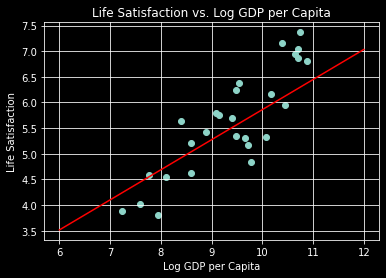

In [17]:
# plotting our pred function
fig, ax = plt.subplots()
ax.scatter(X_test, y_test)
ax.grid()
ax.set_xlabel('Log GDP per Capita')
ax.set_ylabel('Life Satisfaction')
ax.set_title('Life Satisfaction vs. Log GDP per Capita')

x = np.linspace(6, 12, 100)
y = model.coef_[0]*x
ax.plot(x,y,c='red')

## Gravity<a class="anchor" id="section_5_2"></a>

The power of good feature engineering

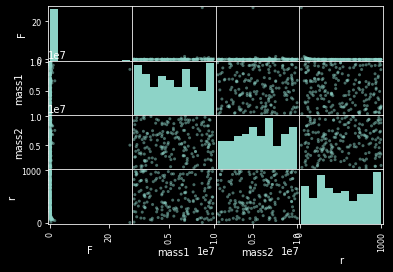

In [19]:
df = pd.read_csv(file_path2)
df.drop(columns=df.columns[0], inplace=True)

pd.plotting.scatter_matrix(df);

In [21]:
# model is for gravitational force: F = Gm1*m2/r**2

df['Feature1'] = df['mass1']*df['mass2']
df['Feature2'] = 1/df['r']**2

df_train, df_test = train_test_split(df, test_size=0.2, random_state=99)
df_test = df_test.copy()

X_train = df_train[['Feature1','Feature2']] 
y_train = df_train['F']

X_test = df_test[['Feature1','Feature2']]
y_test = df_test['F']

model = LinearRegression(fit_intercept=False) # no intercept for illustration
model.fit(X_train, y_train)
y_hat_test = model.predict(X_test)
print(f"Model MSE with 2 features separate:\t{mean_squared_error(y_test, y_hat_test)}")

df['Feature3'] = df['Feature1']*df['Feature2']

df_train, df_test = train_test_split(df, test_size=0.2, random_state=99)
df_test = df_test.copy()

X_train = df_train[['Feature3']] 
y_train = df_train['F']

X_test = df_test[['Feature3']]
y_test = df_test['F']

model = LinearRegression(fit_intercept=False) #no intercept for illustration
model.fit(X_train, y_train)
y_hat_test = model.predict(X_test)
print(f"Model MSE with equation:\t\t{mean_squared_error(y_test, y_hat_test)}")

Model MSE with 2 features separate:	0.04328878089640851
Model MSE with equation:		3.242689101067561e-32


## Gender<a class="anchor" id="section_5_3"></a>

There is a way to separate these with a linear regression

Text(0, 0.5, 'Weight')

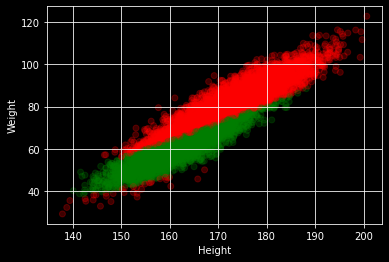

In [22]:
df_train = pd.read_excel(file_path3, 'train')
df_test = pd.read_excel(file_path3, 'test')

#eda
fig, ax = plt.subplots()
ax.scatter(df_train['Height'], df_train['Weight'],
           c = df_train['IsHealthy'].map({1:'green', 0:'red'}),
           alpha = 0.25)
ax.grid()
ax.set_xlabel('Height')
ax.set_ylabel('Weight')

In [23]:
#try 1 - height

X_train = df_train[['Height']]
y_train = df_train['IsHealthy']

X_test = df_test[['Height']]
y_test = df_test['IsHealthy']

model = LogisticRegression()
model.fit(X_train, y_train)

y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)

print(f"Train accuracy:\t{accuracy_score(y_train, y_hat_train)}")
print(f"Test accuracy:\t{accuracy_score(y_test, y_hat_test)}")

Train accuracy:	0.7814201577953106
Test accuracy:	0.7962037962037962


In [24]:
#try 2 - weight

X_train = df_train[['Weight']]
y_train = df_train['IsHealthy']

X_test = df_test[['Weight']]
y_test = df_test['IsHealthy']

model = LogisticRegression() #what the C param that regularises
model.fit(X_train, y_train)

y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)

print(f"Train accuracy:\t{accuracy_score(y_train, y_hat_train)}")
print(f"Test accuracy:\t{accuracy_score(y_test, y_hat_test)}")

Train accuracy:	0.8920991221246806
Test accuracy:	0.9080919080919081


In [25]:
#try 3 - BMI

df_train['BMI'] = df_train['Weight']/((df_train['Height']/100)**2)
df_test['BMI'] = df_test['Weight']/((df_test['Height']/100)**2)

X_train = df_train[['BMI']]
y_train = df_train['IsHealthy']

X_test = df_test[['BMI']]
y_test = df_test['IsHealthy']

model = LogisticRegression() 
model.fit(X_train, y_train)

y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)

print(f"Train accuracy:\t{accuracy_score(y_train, y_hat_train)}")
print(f"Test accuracy:\t{accuracy_score(y_test, y_hat_test)}")

Train accuracy:	0.9912212468052006
Test accuracy:	0.988011988011988


In [26]:
#try 4 - BMI + underweight

df_train['BMI'] = df_train['Weight']/((df_train['Height']/100)**2)
df_test['BMI'] = df_test['Weight']/((df_test['Height']/100)**2)


df_train['IsUnder'] = np.where(df_train['BMI'] < 18.5, 1, 0)
df_test['IsUnder'] = np.where(df_test['BMI'] < 18.5, 1, 0)

X_train = df_train[['BMI', 'IsUnder']]
y_train = df_train['IsHealthy']

X_test = df_test[['BMI','IsUnder']]
y_test = df_test['IsHealthy']

model = LogisticRegression() 
model.fit(X_train, y_train)

y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)

print(f"Train accuracy:\t{accuracy_score(y_train, y_hat_train)}")
print(f"Test accuracy:\t{accuracy_score(y_test, y_hat_test)}")

Train accuracy:	0.9945549505500612
Test accuracy:	0.995004995004995


In [28]:
#try 5 - Overweight + underweight

df_train['BMI'] = df_train['Weight']/((df_train['Height']/100)**2)
df_test['BMI'] = df_test['Weight']/((df_test['Height']/100)**2)

df_train['IsUnder'] = np.where(df_train['BMI'] < 18.5, 1, 0)
df_test['IsUnder'] = np.where(df_test['BMI'] < 18.5, 1, 0)

df_train['IsOver'] = np.where(df_train['BMI'] > 25, 1, 0)
df_test['IsOver'] = np.where(df_test['BMI'] > 25, 1, 0)

X_train = df_train[['IsOver', 'IsUnder']]
y_train = df_train['IsHealthy']

X_test = df_test[['IsOver','IsUnder']]
y_test = df_test['IsHealthy']

model = LogisticRegression()
model.fit(X_train, y_train)

y_hat_test = model.predict(X_test)
y_hat_train = model.predict(X_train)

print(f"Train accuracy:\t{accuracy_score(y_train, y_hat_train)}")
print(f"Test accuracy:\t{accuracy_score(y_test, y_hat_test)}")

print('model coef:' , model.coef_)
print('model intercept:', model.intercept_)

Train accuracy:	1.0
Test accuracy:	1.0
model coef: [[-11.43655631  -6.76483749]]
model intercept: [5.30120742]
